In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import ruamel.yaml
import math
import numpy as np
import tarfile
from matplotlib import cm
from matplotlib import pyplot as plt
import warnings
import yaml
yaml_format = ruamel.yaml.YAML()
warnings.filterwarnings('ignore')

import matplotlib.ticker as ticker  # Add this import at the top


In [22]:
def get_data_dir(subfolder):
    # current_dir = os.path.dirname(os.path.abspath(__file__))
    current_dir = os.getcwd()
    print(current_dir)
    return os.path.join(current_dir, "experiment_data", subfolder)


In [23]:
def derived_papi(PAPI_data):
    DERIVED = {}
    DERIVED['TOT_INS_PER_CYC'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_TOT_INS']['instantaneous_value']) / np.array(PAPI_data['PAPI_TOT_CYC']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_TOT_INS'].time)
    })
    DERIVED['TOT_CYC_PER_INS'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_TOT_CYC']['instantaneous_value']) / np.array(PAPI_data['PAPI_TOT_INS']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_TOT_CYC'].time)
    })
    DERIVED['L3_TCM_PER_TCA'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_L3_TCM']['instantaneous_value']) / np.array(PAPI_data['PAPI_L3_TCA']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_L3_TCM'].time)
    })  
    DERIVED['TOT_STL_PER_CYC'] = pd.DataFrame({
        'value': np.array(PAPI_data['PAPI_RES_STL']['instantaneous_value']) / np.array(PAPI_data['PAPI_TOT_CYC']['instantaneous_value']),
        'timestamp': np.array(PAPI_data['PAPI_RES_STL'].time)
    })
    
    # Create a mask for non-NaN values across all keys
    mask = ~DERIVED['TOT_INS_PER_CYC']['value'].isna()  # Start with one key to create the mask
    for key in DERIVED:
        mask &= ~DERIVED[key]['value'].isna()  # Combine masks for all keys

    for key in DERIVED:
        DERIVED[key] = DERIVED[key][mask]  # Filter each DataFrame using the combined mask

    return DERIVED

def calculate_power_with_wraparound(current, previous, time_diff, wraparound_value=262143.328850):
    diff = current - previous
    if diff < 0:  # Wraparound detected
        diff = (wraparound_value - previous) + current
    return diff / time_diff

def compute_power(pubEnergy,power_data=None):
    power = {}
    geopm_sensor0 = geopm_sensor1 = pd.DataFrame({'timestamp':[],'value':[]})
    for i,row in pubEnergy.iterrows():
        if i%2 == 0:
            geopm_sensor0 = pd.concat([geopm_sensor0, pd.DataFrame([{'timestamp': row['time'], 'value': row['value']}])], ignore_index=True)
        else:
            geopm_sensor1 = pd.concat([geopm_sensor1, pd.DataFrame([{'timestamp': row['time'], 'value': row['value']}])], ignore_index=True)


    power['geopm_power_0'] = pd.DataFrame({
        'timestamp': geopm_sensor0['timestamp'][1:],  # Add timestamps
        'power': [
            calculate_power_with_wraparound(
                geopm_sensor0['value'][i],
                geopm_sensor0['value'][i-1],
                geopm_sensor0['timestamp'][i] - geopm_sensor0['timestamp'][i-1]
            ) for i in range(1, len(geopm_sensor0))
        ]
    })

    # Apply the same logic to geopm_power_1
    power['geopm_power_1'] = pd.DataFrame({
        'timestamp': geopm_sensor1['timestamp'][1:],  # Add timestamps
        'power': [
            calculate_power_with_wraparound(
                geopm_sensor1['value'][i],
                geopm_sensor1['value'][i-1],
                geopm_sensor1['timestamp'][i] - geopm_sensor1['timestamp'][i-1]
            ) for i in range(1, len(geopm_sensor1))
        ]
    })


    power['geopm0'] = geopm_sensor0.diff()
    power['geopm0_time'] = geopm_sensor0['timestamp']-geopm_sensor0['timestamp'].iloc[0]
    power['geopm1'] = geopm_sensor1.diff()
    power['geopm1_time'] = geopm_sensor1['timestamp']-geopm_sensor1['timestamp'].iloc[0]
    min_length = min(len(power['geopm_power_0']), len(power['geopm_power_1']))
    geopm_power_0 = power['geopm_power_0'][:min_length]
    geopm_power_1 = power['geopm_power_1'][:min_length]
    # fig,axs = plt.subplots(3,1)
    # axs[0].plot(geopm_power_0['timestamp'], geopm_power_0['power'], label='Node 0')
    # axs[1].plot(geopm_power_1['timestamp'], geopm_power_1['power'], label='Node 1')

    average_power = pd.DataFrame({
        'timestamp': geopm_power_0['timestamp'],  # Use the timestamp from geopm_power_0
        'average_power': [(p0 + p1) / 2 for p0, p1 in zip(geopm_power_0['power'], geopm_power_1['power'])]
    })
    average_power['elapsed_time'] = average_power['timestamp'] - average_power['timestamp'].iloc[0]
    # axs[2].plot(average_power['timestamp'], average_power['average_power'], label='Average Power', color='green')
    power['average_power'] = average_power
    return power

def measure_progress(progress_data, energy_data):
    Progress_DATA = {} 
    progress_sensor = pd.DataFrame(progress_data)
    first_sensor_point = min(energy_data['average_power']['timestamp'].iloc[0], progress_sensor['time'][0])
    progress_sensor['elapsed_time'] = progress_sensor['time'] - first_sensor_point  # New column for elapsed time
    # progress_sensor = progress_sensor.set_index('elapsed_time')
    performance_elapsed_time = progress_sensor.elapsed_time
    # Add performance_frequency as a new column in progress_sensor
    frequency_values = [
        progress_data['value'].iloc[t] / (performance_elapsed_time[t] - performance_elapsed_time[t-1]) for t in range(1, len(performance_elapsed_time))
    ]
    
    # Ensure the frequency_values length matches the index length
    frequency_values = [0] + frequency_values  # Prepend a 0 for the first index
    progress_sensor['frequency'] = frequency_values
    upsampled_timestamps= energy_data['average_power']['timestamp']
    
    # true_count = (progress_sensor['time'] <= upsampled_timestamps.iloc[0]).sum()

    progress_frequency_median = pd.DataFrame({'median': np.nanmedian(progress_sensor['frequency'].where(progress_sensor['time'] <= upsampled_timestamps.iloc[0])), 'timestamp': upsampled_timestamps.iloc[0]}, index=[0])
    for t in range(1, len(upsampled_timestamps)):
        progress_frequency_median = pd.concat([progress_frequency_median, pd.DataFrame({'median': [np.nanmedian(progress_sensor['frequency'].where((progress_sensor['time'] >= upsampled_timestamps.iloc[t-1]) & (progress_sensor['time'] <= upsampled_timestamps.iloc[t])))],
        'timestamp': [upsampled_timestamps.iloc[t]]})], ignore_index=True)
    progress_frequency_median['elapsed_time'] = progress_frequency_median['timestamp'] - progress_frequency_median['timestamp'].iloc[0]
    # Assign progress_frequency_median as a new column
    Progress_DATA['progress_sensor'] = progress_sensor
    Progress_DATA['progress_frequency_median'] = progress_frequency_median
    return Progress_DATA

def collect_papi(PAPI_data):
    PAPI = {}
    for scope in PAPI_data['scope'].unique():
        # Extract the string between the 3rd and 4th dots
        scope_parts = scope.split('.')
        if len(scope_parts) > 4:  # Ensure there are enough parts
            extracted_scope = scope_parts[3]
            # Aggregate the data for the extracted scope using pd.concat
            PAPI[extracted_scope] = PAPI_data[PAPI_data['scope'] == scope]
            instantaneous_values = [0] + [PAPI[extracted_scope]['value'].iloc[k] - PAPI[extracted_scope]['value'].iloc[k-1] for k in range(1,len(PAPI[extracted_scope]))]
            # Normalize the instantaneous values between 0 and 10
            # min_val = min(instantaneous_values)
            # max_val = max(instantaneous_values)
            PAPI[extracted_scope]['instantaneous_value'] = instantaneous_values
            PAPI[extracted_scope]['elapsed_time'] = PAPI[extracted_scope]['time'] - PAPI[extracted_scope]['time'].iloc[0]
    return PAPI


def generate_PCAP(PCAP_data):
    for row in PCAP_data.iterrows():
        if row[1]['time'] == 0:
            PCAP_data = PCAP_data.drop(row[0])


    PCAP_data['elapsed_time'] = PCAP_data['time'] - PCAP_data['time'].iloc[0]
    return PCAP_data


/home/akhilesh/Desktop/summer2024/main_codes
ones-stream-scale


Index(['timestamp', 'value'], dtype='object')


KeyError: 'geopm0_time'

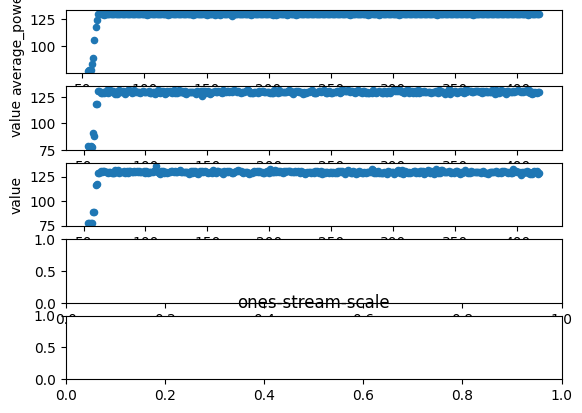

In [26]:

DATA_DIR = get_data_dir('Control')
root,folders,files = next(os.walk(DATA_DIR))
test_results_control = {}
for APP in folders:
    print(APP)
    APP_DIR = os.path.join(DATA_DIR, APP)
    test_results_control[APP] = {}
    for file in next(os.walk(APP_DIR))[2]:
        test_results_control[APP][file] = {}
        if file.endswith('.tar'):
            tar_path = os.path.join(APP_DIR, file)
            extract_dir = os.path.join(APP_DIR, file[:-4])  
            
            if not os.path.exists(extract_dir):
                os.makedirs(extract_dir)
            
            with tarfile.open(tar_path, 'r') as tar:
                tar.extractall(path=extract_dir)
            
        pubProgress = pd.read_csv(f'{extract_dir}/progress.csv')
        pubEnergy = pd.read_csv(f'{extract_dir}/energy.csv')
        pubPAPI = pd.read_csv(f'{extract_dir}/papi.csv')
        pubPCAP = pd.read_csv(f'{extract_dir}/PCAP_file.csv')
        pubPower = pd.read_csv(f'{extract_dir}/measured_power.csv')
        test_results_control[APP][file]['energy'] = pubEnergy
        test_results_control[APP][file]['power'] = compute_power(pubEnergy,power_data=pubPower)
        test_results_control[APP][file]['progress'] = measure_progress(pubProgress,test_results_control[APP][file]['power'])
        test_results_control[APP][file]['papi'] = collect_papi(pubPAPI)
        test_results_control[APP][file]['PCAP'] = generate_PCAP(pubPCAP)
        test_results_control[APP][file]['derived_papi'] = derived_papi(test_results_control[APP][file]['papi'])
        test_results_control[APP][file]['pubPower'] = pubPower
        test_results_control[APP][file]['pubPower0'] = pubPower[pubPower['scope'] == 0] 
        test_results_control[APP][file]['pubPower1'] = pubPower[pubPower['scope'] == 1]
    fig,axs = plt.subplots(5,1)
    plt.title(APP)
    test_results_control[APP][file]['power']['average_power'].plot(x='timestamp', y='average_power', ax=axs[0], kind='scatter')  # Change to scatter plot
    test_results_control[APP][file]['pubPower0'].plot(x='time', y='value', ax=axs[1], kind='scatter')  # Change to scatter plot
    test_results_control[APP][file]['pubPower1'].plot(x='time', y='value', ax=axs[2], kind='scatter')  # Change to scatter plot
    # test_results_control[APP][file]['power']['geopm_power_0'].plot(x='timestamp', y='power', ax=axs[3], kind='scatter')  # Change to scatter plot
    # test_results_control[APP][file]['power']['geopm_power_1'].plot(x='timestamp', y='power', ax=axs[4], kind='scatter')  # Change to scatter plot

    print(test_results_control[APP][file]['power']['geopm0'].columns)

    test_results_control[APP][file]['power']['geopm0'].plot(x='geopm0_time',y='value', ax=axs[3], kind='scatter')  # Change to scatter plot
    test_results_control[APP][file]['power']['geopm1'].plot(x='timestamp', y='value', ax=axs[4], kind='scatter')  # Change to scatter plot

In [2]:
# print("test",test_results.keys())
# print("test",test_results_control.keys())

fig_test,axs_test = plt.subplots(3,1)
app = 'ones-stream-full'
file_t = 'compressed_iteration_20250109_222723.tar'
print(test_results_control[app][file_t]['power'].keys())
print(test_results_control[app][file_t]['power']['geopm_power_1'].keys())

axs_test[0].plot(range(len(test_results_control[app][file_t]['power']['average_power']['elapsed_time'])), test_results_control[app][file_t]['power']['average_power']['average_power'])
axs_test[1].plot(
    range(len(test_results_control[app][file_t]['pubPower'][test_results_control[app][file_t]['pubPower']['scope'] == 0]['value'])), 
    test_results_control[app][file_t]['pubPower'][test_results_control[app][file_t]['pubPower']['scope'] == 0]['value']
)
axs_test[2].plot(
    range(len(test_results_control[app][file_t]['pubPower'][test_results_control[app][file_t]['pubPower']['scope'] == 1]['value'])), 
    test_results_control[app][file_t]['pubPower'][test_results_control[app][file_t]['pubPower']['scope'] == 1]['value']
)


NameError: name 'plt' is not defined